# What & Why
This notebook is inspired by Jeremy's [notebook](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-)  in the [lesson 6 of the course](https://course.fast.ai/Lessons/lesson6.html). It creates a baseline submission for [Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification) competition.

It's a manual replica of Jeremy's notebook with notes to myself and updates to make it work on Paperspace in Aug 2024.

My goal was to make it work on Paperspace and automatically submit to Kaggle from there.

# Python packages setup & data download

In [1]:
USE_LATEST_PIP_PACKAGES = True

In [2]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    print("Running notebook in kaggle mode")
else:
    print("Running notebook in Paperspace mode")

Running notebook in Paperspace mode


In [3]:
# install Jeremy's fastkaggle package with helpers for Kaggle API
try:
    import fastkaggle
except ModuleNotFoundError:
    if is_kaggle:
        print("installing fastkaggle into system folder on Kaggle")
        !pip install -q fastkaggle
    else:
        print("installing fastkaggle into user (/root/.local/) folder on Paperspace")
        # we are installing into local folder
        !pip install --user -q fastkaggle

from fastkaggle import setup_comp, push_notebook

In [4]:
# Jeremy's philosophy is to always work on latest versions of all packages 
# and don't bother with creating and tracking Python environments with the fixed set of packages
# I still like to have full replica of the env, so plan to add it as a fallback
if not is_kaggle:
    if USE_LATEST_PIP_PACKAGES:
        !pip install --user -Uqq timm huggingface_hub fastai
    else:
        # todo: add pip freeze for paperspace setup or install from requirements
        raise Exception("Not implemented")

## Get compteition data

In [5]:
# setup_comp downloads competition dataset archive into the current folder and extracts into subfolder
# it also pip-installs libraries when if we are on Kaggle
COMPETITION_NAME = 'paddy-disease-classification'

path = setup_comp(COMPETITION_NAME, install='timm huggingface_hub fastai')

In [6]:
# import fastai only after we updated all packages on Kaggle or locally
from fastai.vision.all import *
from fastcore.parallel import *
set_seed(42)

In [7]:
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

# Quick look at data

In [8]:
train_path = path / "train_images"

In [9]:
train_files = get_image_files(train_path)

File:  paddy-disease-classification/train_images/tungro/100723.jpg
Size:  (480, 640)


<AxesSubplot:>

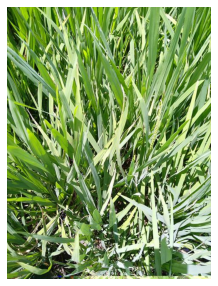

In [10]:
# show single file
idx = 2002
img = PILImage.create(train_files[idx])
print("File: ", train_files[idx])
print("Size: ", img.size)
img.show()

In [11]:
## check size of all images

In [12]:
def get_image_size(file_path):
    return PILImage.create(file_path).size

assert get_image_size(train_files[0]) == (480, 640)

In [13]:
%%time
sizes = parallel(get_image_size, train_files, n_workers=8)
pd.Series(sizes).value_counts()

CPU times: user 4.91 s, sys: 1.04 s, total: 5.95 s
Wall time: 41.4 s


(480, 640)    10403
(640, 480)        4
dtype: int64

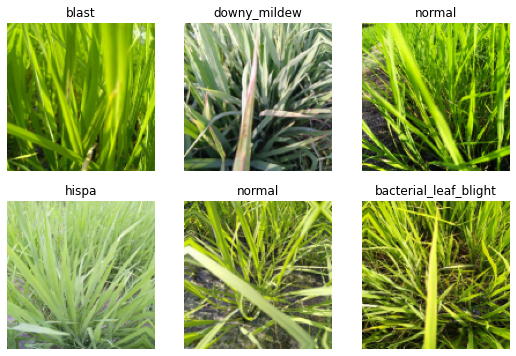

In [14]:
dls = ImageDataLoaders.from_folder(
    train_path, valid_pct=0.2, seed=42, 
    item_tfms=Resize(480, method="squish"), # resize all images to the same size on loading
    batch_tfms=aug_transforms(size=128, min_scale=0.75) # I'm not sure of benefits of resizing 2 times - on load and per batch
)
dls.show_batch(max_n=6)

## Train the model

In [15]:
?error_rate

Signature: error_rate(inp, targ, axis=-1)
Docstring: 1 - `accuracy`
File:      ~/.local/lib/python3.9/site-packages/fastai/metrics.py
Type:      function


In [16]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0003311311302240938, slide=0.0020892962347716093)

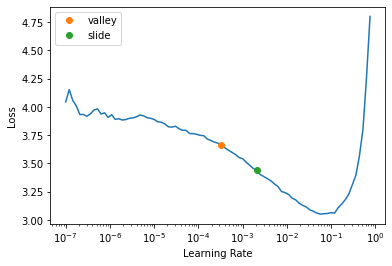

In [17]:
learn.lr_find(suggest_funcs=(valley, slide))

In [18]:
%%time
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.763914,1.349224,0.420471,00:34


epoch,train_loss,valid_loss,error_rate,time
0,1.126082,0.822354,0.271504,00:38
1,0.762823,0.469286,0.149447,00:40
2,0.555997,0.383284,0.121576,00:40


CPU times: user 1min 32s, sys: 36.1 s, total: 2min 8s
Wall time: 2min 34s


# Make predictions on test files

In [19]:
test_files = get_image_files( path / 'test_images').sorted()
test_dl = dls.test_dl(test_files)

In [20]:
predicted_probs,_,predicted_idxs = learn.get_preds(dl=test_dl, with_decoded=True)
predicted_idxs

tensor([7, 8, 7,  ..., 8, 7, 5])

In [21]:
predicted_probs[0]

tensor([8.2603e-04, 2.4339e-06, 3.7617e-07, 2.1538e-04, 8.0793e-02, 3.0611e-04,
        7.5716e-05, 9.1743e-01, 1.2754e-04, 2.2826e-04])

In [22]:
category_names = dls.vocab
category_names

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [23]:
category_names[predicted_idxs.numpy()]

(#3469) ['hispa','normal','hispa','blast','blast','brown_spot','dead_heart','brown_spot','normal','normal'...]

# Create submission file and post via API to Kaggle

In [24]:
import pandas as pd

In [25]:
subm_df = pd.read_csv(path / 'sample_submission.csv')
subm_df

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [26]:
subm_df['label'] = category_names[predicted_idxs.numpy()]

In [27]:
assert subm_df["label"].isnull().sum() == 0

In [28]:
subm_df.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,normal


In [30]:
if not is_kaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'baseline resnet26d 128px', COMPETITION_NAME)

100%|██████████| 69.7k/69.7k [00:00<00:00, 242kB/s]


# Push notebook to Kaggle

In [32]:
if not is_kaggle:
    push_notebook('stware', 'paddy-01-baseline',
                  title='Paddy: 01 baseline',
                  file='01-baseline.ipynb',
                  competition=COMPETITION_NAME, private=False, gpu=True,  internet=True)

Kernel version 3 successfully pushed.  Please check progress at https://www.kaggle.com/code/stware/paddy-01-baseline
